In [2]:
# %pip install tensorflow
# %pip install gym
# %pip install keras
# %pip install keras-rl2
# %pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

In [2]:
from gym import Env
from gym.spaces import Discrete, Box
from matplotlib import pyplot as plt
from mss import mss
import numpy as np 
import time
import pydirectinput
import pygetwindow
import cv2
import win32gui
import gym as gym
from image_analysis.take_screenshot import Screenshot
from input_sending.input_sending import SendInput 
from pattern_recognition.pattern_recog import RecognizePattern 

In [3]:
class StepManiaEnv(Env):
    
    # Setup
    def __init__(self):
        super().__init__()
        self.action_space = Discrete(5)

        # Observation Array
        self.observation_space = Box(
            low=0, 
            high=255, 
            shape=(1, 135, 100),
            dtype=np.uint8
        )
        
        # Define extraction parameters for the game
        self.screenshot_helper = Screenshot()
        self.input_sending_helper = SendInput()
        self.pattern_recog_helper = RecognizePattern()
        self.capture = mss()
        self.steps = 0
        self.previous_reward = 0
        self.window_location = {'top': 35, 'left': 10, 'width': 410, 'height': 230}
        self.game_location = {'top': 15, 'left': 20, 'width': 100, 'height': 185}
        self.score_location = {'top': 215, 'left': 280, 'width': 100, 'height': 25}
        self.done_location = {'top': 0, 'left': 0, 'width': 90, 'height':25}
        self.cur_held_buttons = {'a': False, 'd': False, 'w': False, 's': False}
        
        # Adjust window position and size
        win = pygetwindow.getWindowsWithTitle('StepMania')[0]
        win.size = (450, 290)
        win.moveTo(0, 0)

    # One iteration of the environment
    def step(self, action):
        
        # Action dictionary
        action_map = {
            0:'no_op',
            1:'a',
            2:'d',
            3:'w',
            4:'s',
        }

        # Manage and send input based on action parameter
        if action != 0:
            if (list(self.cur_held_buttons.values())[action - 1]):
                self.cur_held_buttons[list(self.cur_held_buttons)[action - 1]] = False
                self.input_sending_helper.releaseKey(action_map[action])
            else:
                self.cur_held_buttons[list(self.cur_held_buttons)[action - 1]] = True
                self.input_sending_helper.holdKey(action_map[action])
        
        
        # Take screenshot for done, observation and reward functions
        screenshot = np.array(self.capture.grab(self.window_location))[:,:,:-1].astype(np.uint8)
        downscaled_screenshot = self.screenshot_helper.downscaleImage(screenshot, (225, 150), (1, 150, 225))
        self.steps += 1
        
        # Checking if the game is over
        done = self.get_over(screenshot)
        
        # Get the next observation
        new_observation = self.get_observation(downscaled_screenshot)
        
        # Use score as reward
        reward = self.get_reward(screenshot)
        info = {}

        return new_observation, reward, done, info

    # Quits result screen and selects new song
    def reset(self):
        
        # Exit to menu, select new song and start
        time.sleep(5)
        pydirectinput.press('enter')
        time.sleep(6)
        pydirectinput.press('d')
        time.sleep(2)
        pydirectinput.press('enter')

        # Edge Case - 'Roulette' is selected
        time.sleep(1.5)
        pydirectinput.press('enter')
        time.sleep(3)
        pydirectinput.press('enter')

        # Reset reward
        self.previous_reward = 0
        self.steps = 0

        # Take screenshot to pass to observation
        screenshot = np.array(self.capture.grab(self.window_location))[:,:,:-1].astype(np.uint8)
        downscaled_screenshot = self.screenshot_helper.downscaleImage(screenshot, (225, 150), (1, 150, 225))
        
        return self.get_observation(downscaled_screenshot)

    # Returns image of gameplay
    def get_observation(self, img):

        # Crop gameplay part of the window screenshot
        obs = img[:, self.game_location['top']:(self.game_location['top'] + self.game_location['height']), self.game_location['left']:(self.game_location['left'] + self.game_location['width'])]

        return obs

    # Returns the current score as a reward
    def get_reward(self, img):

        # Crop score part of the window screenshot
        obs = img[self.score_location['top']:(self.score_location['top'] + self.score_location['height']), self.score_location['left']:(self.score_location['left'] + self.score_location['width'])]
        
        # Calculate the reward by subtracting the previous score from the current score
        # If the song is over, or the score isn't recognized properly, set reward to 0 to avoid accidently returning a negative reward
        new_reward = self.pattern_recog_helper.analyze_score(obs)
        if (new_reward > self.previous_reward):
            reward = new_reward - self.previous_reward
            # Set the current reward as the previous reward for the next iteration
            self.previous_reward = new_reward
        else:
            reward = 0
        return reward

    # Checks if the game is over
    def get_over(self, img):

        # Crop done part of the window screenshot
        obs = img[self.done_location['top']:(self.done_location['top'] + self.done_location['height']), self.done_location['left']:(self.done_location['left'] + self.done_location['width'])]
        
        return self.pattern_recog_helper.analyze_results(obs)


In [25]:
env = StepManiaEnv()

In [ ]:
print('Environment started - Using random inputs')
time.sleep(2)
for episode in range(10):
  done = False
  start = time.perf_counter()
  while not done:
    obs, reward, done, info = env.step(env.action_space.sample())

  stop = time.perf_counter()
  final_time = stop - start
  print(f'Total Reward for episode {episode} is {env.previous_reward}')
  print(f'Total steps during this episode: {env.steps}')
  print(f'Total duration of this episode is {final_time:0.4f} seconds')
  print(f'This equals an average of {env.steps / final_time} images per second')
  env.reset()

In [4]:
import os
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import env_checker

In [51]:
# Check if the environment is valid
env_checker.check_env(env)

In [5]:
# Define callback function, that is called after every step
# This is used to save the model in regular intervals
class TrainAndLoggingCallback(BaseCallback):
  def __init__(self, checking_freq, save_path, verbose=1):
    super(TrainAndLoggingCallback, self).__init__(verbose)
    self.checking_freq = checking_freq
    self.save_path = save_path

  def _init_callback(self):
    if self.save_path is not None:
      os.makedirs(self.save_path, exist_ok=True)

  def _on_step(self):
    if (self.num_timesteps % 500 == 0):
      self.logger.dump(self.num_timesteps)
    if self.n_calls % self.checking_freq == 0:
      model_path = os.path.join(self.save_path, f'best_model_{self.n_calls}')
      self.model.save(model_path)
    
    return True

In [6]:
CHECKPOINT_DIR = './training/'
LOG_DIR = './logs/'

In [7]:
callback = TrainAndLoggingCallback(checking_freq=1_000, save_path=CHECKPOINT_DIR)

In [8]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor

In [19]:
env = StepManiaEnv()

In [10]:
# Wrap environment to monitor performance and training process
env = gym.make("StepManiaEnv-v1")
env = Monitor(env, filename="./logs/stepmania-env-v1")

In [20]:
ss = np.array(env.capture.grab(env.window_location))[:,:,:-1].astype(np.uint8)
ss_ds = env.get_observation(ss)
plt.imshow(ss_ds[0])

NameError: name 'self' is not defined

In [11]:
model = DQN(
  'CnnPolicy',              
  env,                      # Used environment
  tensorboard_log=LOG_DIR,  # Log directory
  verbose=1,                # Enables logging
  learning_rate=0.0005,     # Learning rate of the optimizer used in training
  buffer_size=120_000,      # Buffer size depending on amount of ram
  learning_starts=1_000,    # Learning starts after 1000 steps
  # device='cpu'              # Training on cpu or gpu
)

Using cuda device
Wrapping the env in a DummyVecEnv.


In [ ]:
# Start training
model.learn(total_timesteps=20_000, callback=callback, log_interval=1)

In [17]:
# Load past model 
model.load(r'training\best_model_10000')

In [18]:
print('Environment started - Using Model')
for episode in range(10):
  obs = env.reset()
  done = False
  final_reward = 0
  start = time.perf_counter()
  while not done:
    action, _ = model.predict(obs)
    obs, reward, done, info = env.step(int(action))
    final_reward = reward

  stop = time.perf_counter()
  final_time = stop - start

  print(f'Total Reward for episode {episode} is {env.previous_reward}')
  print(f'Total steps during this episode: {env.steps}')
  print(f'Total duration of this episode is {final_time:0.4f} seconds')
  print(f'This equals an average of {env.steps / final_time} images per second')

Environment started - Using Model


KeyboardInterrupt: 

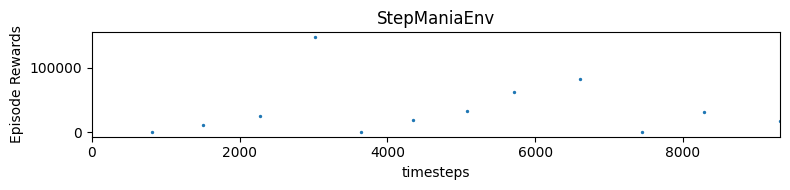

In [49]:
from stable_baselines3.common import results_plotter

results_plotter.plot_results(
  [LOG_DIR], 10000, results_plotter.X_TIMESTEPS, "StepManiaEnv"
)